In [107]:
import cv2
import numpy as np
from PIL import Image

from typing import Tuple, List
from src.video import skip_intro
from src.video import go_to_next
from src.image import quantize_palette
from src.image import COLOR

video_path = 'video/exile - Taylor Swift & Bon Iver  Piano Tutorial.mp4'

capture = cv2.VideoCapture(video_path)
fps = capture.get(cv2.CAP_PROP_FPS)

data = skip_intro(capture)

palette = [COLOR.WHITE, COLOR.BLACK, COLOR.RED, COLOR.GREEN]

music = [data := go_to_next(capture, data[0], thr=5e-4) for i in range(500)]
frames = [frame for frame, _ in music]
frames = [quantize_palette(frame, palette=palette, color_enhance=10) for frame in frames]

# NOTE: Because our functions measures the SKIPPED number of frames, to actually
#       measure the duration of each frame we need to referred to the next frame
#       skipped frames to know how long the previous frame lasted, with the last
#       detected frame having an unknown duration because we haven't detected its
#       end yet! Moreover, we discard how many skipped frame there were for the
#       intro as that's of no use to us. We mark unknown duration with [0].
times  = [time  for _, time  in music[1:]] + [0]

ModuleNotFoundError: No module named 'src.video'

In [1]:
import importlib
import src.video
importlib.reload(src.video)
from src.video import get_frames

video_path = 'video/exile - Taylor Swift & Bon Iver  Piano Tutorial.mp4'

frames, times, info = get_frames(
    video_path,
    max_frames=0.6,
    verbose=True,
    black_flags=(196, 232),
)

/Users/paolomuratore/.pyenv/versions/3.11.9/envs/Music/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Extracting Frames: 5212it [01:05, 79.01it/s]                          


In [41]:
times[:10]

[24, 1, 11, 6, 6, 2, 10, 13, 1, 5]

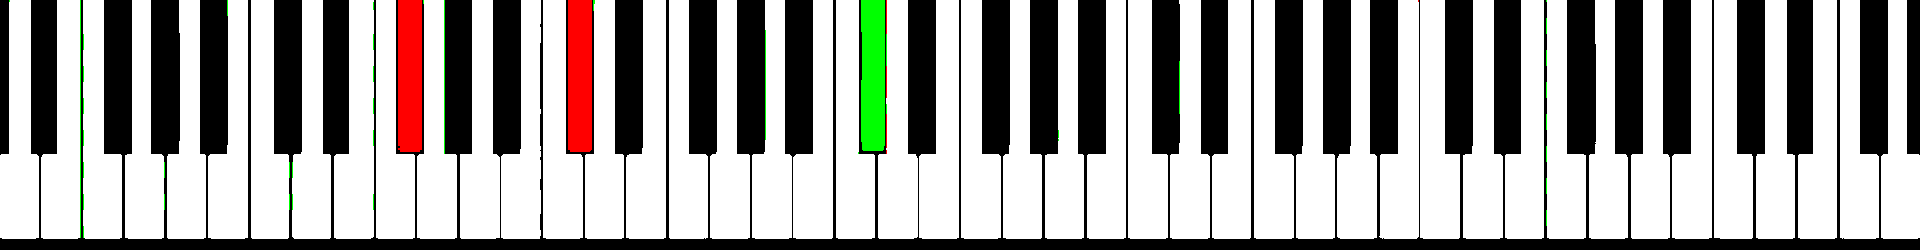

In [45]:
from src.image import frame_to_pil

frame_to_pil(frames[6])

In [2]:
import importlib
import src.keyboard
import src.image
importlib.reload(src.image)
importlib.reload(src.keyboard)
from itertools import pairwise
from src.image import bbox_notes
from src.keyboard import find_notes
from src.keyboard import get_keyboard_layout
from src.keyboard import get_keyboard_spacings

from src.image import COLOR

from tqdm.auto import tqdm

notation = 'flat'

music = {
    'left-hand' : [],
    'right-hand': [],
}

color_hand_map = {
    # ! FIXME: It puzzles me why we need to put .value here but somehow
    # !        we get a KeyError if we don't.
    COLOR.RED.value   : 'left-hand',
    COLOR.GREEN.value : 'right-hand'
}

layout = get_keyboard_layout(
    # separate_bw=True,
    num_octaves=7,
    start_octave=1,
    start_note='D',
    end_note='G',
    black_key_notation=notation,
    trim_key_layout=True,
    clean_fake_keys=True,
)

spacings = get_keyboard_spacings(
    num_octaves=7,
    start_note='D',
    end_note='G',
    black_key_notation=notation,
)

for idx, frame in enumerate(tqdm(frames, desc='Parsing frames')):
    notes = find_notes(
        bbox_notes(
            frame,
            noise_cutoff=(0.2, 0.8),
            cutoff_value=(0, 0),
            color_use_enum=True,
        ),
        key_layout = layout,
        key_spacings = spacings,
        color_hand_map = color_hand_map,
    )

    music['left-hand' ].append(notes['left-hand'])
    music['right-hand'].append(notes['right-hand'])

# Check for both hand overlap on the same note (a gap)
# and fill it when appropriate 
hands = ('left-hand', 'right-hand', 'left-hand')
for one, other in pairwise(hands):
    for idx in range(len(frames)):
        notes = music[one][idx]
        for note in notes:
            is_gap = note in music[other][idx-1] and note in music[other][idx+1] and note not in music[other][idx] 
            if is_gap: music[other][idx].append(note)

Parsing frames: 100%|██████████| 918/918 [00:21<00:00, 43.23it/s]


In [147]:
def clean_music(
    music,
    times,
):
    flags = []

    for time, (pred, succ) in zip(times[1:], pairwise(range(len(times)))):
        for name in music:
            if time == 1 and any([n not in music[name][pred] for n in music[name][succ]]):
                flags.append(succ)

    flags = set(flags)
    for name in music:
        music[name] = [v for idx, v in enumerate(music[name]) if idx not in flags]

    times = [t for idx, t in enumerate(times) if idx not in flags]

    return music, times

music, times = clean_music(music, times)

In [26]:
import importlib
import src.timings
importlib.reload(src.timings)
from src.timings import attach_times

tmp_music = {}
tmp_times = times[40:60]
tmp_music['right-hand'] = music['right-hand'][40:60]
tmp_music['left-hand'] = music['left-hand'][40:60]

attach_times(tmp_music, tmp_times, fps=fps, min_t_frame=0.1)

{'right-hand': [{'G#-3': 0.33366666666666667,
   'T_FRAME': 0.33366666666666667,
   'T_ELAPSED': 0.0},
  {'F#-3': 0.40040000000000003,
   'T_FRAME': 0.40040000000000003,
   'T_ELAPSED': 0.33366666666666667},
  {'D#-3': 0.23356666666666667,
   'T_FRAME': 0.23356666666666667,
   'T_ELAPSED': 0.7340666666666666},
  {'F#-3': 0.40040000000000003,
   'T_FRAME': 0.40040000000000003,
   'T_ELAPSED': 0.9676333333333333},
  {'D#-3': 0.20020000000000002,
   'T_FRAME': 0.20020000000000002,
   'T_ELAPSED': 1.3680333333333334},
  {'T_FRAME': 0.40040000000000003, 'T_ELAPSED': 1.5682333333333334},
  {'A#-4': 0.20020000000000002,
   'C#-4': 0.20020000000000002,
   'A#-3': 0.20020000000000002,
   'T_FRAME': 0.20020000000000002,
   'T_ELAPSED': 1.9686333333333335},
  {'A#-4': 0.16683333333333333,
   'C#-4': 0.16683333333333333,
   'A#-3': 0.16683333333333333,
   'T_FRAME': 0.16683333333333333,
   'T_ELAPSED': 2.2022},
  {'A#-4': 0.3670333333333333,
   'C#-4': 0.3670333333333333,
   'A#-3': 0.367033333333

In [4]:
import importlib
import src.timings
importlib.reload(src.timings)
from src.timings import attach_times
from src.timings import get_partition

timed = attach_times(music, times, fps=info['fps'], min_t_frame=0.1)
# print(timed['right-hand'])
# print(timed['left-hand'])
part = get_partition(timed, quarter_bpm=74, minimum_unit=16)
# print(part['right-hand'])

In [12]:
import importlib
import src.sheet
import src.misc
importlib.reload(src.misc)
importlib.reload(src.sheet)
import abjad
from src.sheet import get_score

score = get_score(
    partition=part,
    key='gf',
    clef={
        'left-hand' : 'bass',
        'right-hand' : {
            0 : 'bass',
            4 : 'treble',
        }
    },
    metronome_beat=74,
    metronome_feel='Nostalgico',
    verbose=True,
)

preamble = r'''
    #(set-global-staff-size 20)
    \header {
        composer = \markup { Arranged by The Theorist }
        subtitle = \markup { A song from Bon Iver & Taylor Swift }
        title = \markup { Exile }
    }

    \layout {
        indent = 1
    }
'''

lily_file = abjad.LilyPondFile([preamble, score])

abjad.show(lily_file, output_directory='out', render_prefix='tmp', should_open=False)

Creating score | Left-hand:   0%|          | 0/52 [00:00<?, ?it/s]WARNING: yacc table file version is out of date
Creating score | Left-hand: 100%|██████████| 52/52 [00:00<00:00, 224.98it/s]
Creating score | Right-hand: 100%|██████████| 52/52 [00:00<00:00, 494.63it/s]


In [49]:
from abjad import Chord, StartSlur, StopSlur

chord1 = Chord('<a bf  cs>1')
chord2 = Chord('<a e cs>1')

abjad.attach(StartSlur(), chord1.note_heads[0])

AssertionError: NoteHead('cs')

In [64]:
from abjad import Duration

dur1 = Duration(10, 16)

new_dur = dur1.equal_or_lesser_assignable

dur1 - new_dur

Duration(1, 8)

In [94]:
a = Note('bf4')

str(a).split("'")[1]

'bf4'

[((0.5125, 0.0, 0.011979166666666667, 0.608), <COLOR.GREEN: (0, 255, 0)>)] defaultdict(<class 'list'>, {'right-hand': ['Gb-4']})


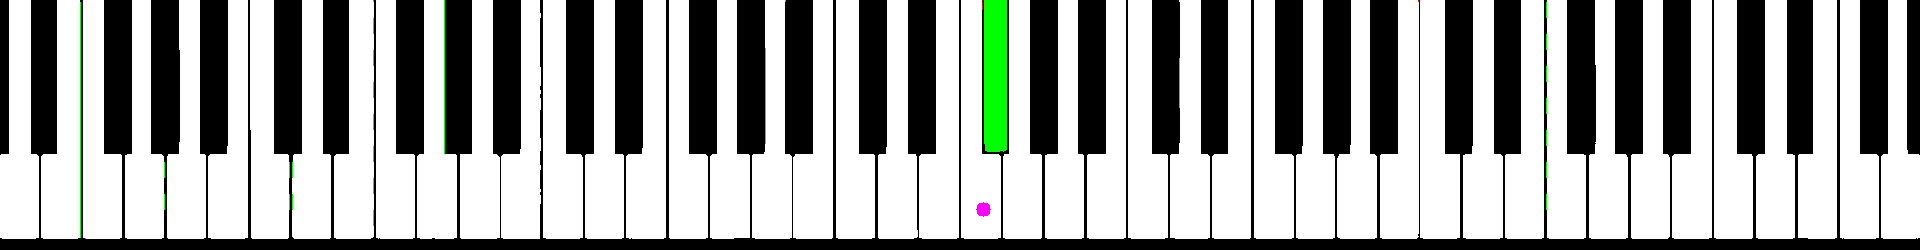

In [197]:
import importlib
import src.keyboard
import src.image
importlib.reload(src.image)
from src.image import frame_threshold
from src.image import frame_to_pil
from src.image import bbox_notes
from src.image import quantize_palette

idx = 196
bbox = bbox_notes(
            frames[idx],
            noise_cutoff=(0.2, 0.8),
            cutoff_value=(0, 0),
            color_use_enum=True,
        )
print(
    bbox,
    find_notes(
        bbox,
        key_layout = layout,
        key_spacings = spacings,
        color_hand_map = color_hand_map,
    )
)

chords = frames[idx].copy()
h, w, c = chords.shape

w_sp, b_sp = spacings

x, y, bw, bh = bbox[0][0]
cv2.circle(chords, (int(x * w), h - h // 6), 2, (255, 0, 255), 10)

# tmp = quantize_palette(frames[2], palette=palette)
frame_to_pil(chords)

In [40]:
bbox

[((0.3338541666666667, 0.0, 0.0015625, 0.592), <COLOR.GREEN: (0, 255, 0)>),
 ((0.321875, 0.0, 0.011458333333333333, 0.604), <COLOR.RED: (255, 0, 0)>)]

In [23]:
find_notes(
    bbox,
    key_layout = layout,
    key_spacings = spacings,
    color_hand_map = color_hand_map,
)

defaultdict(list, {'right-hand': ['Eb-3'], 'left-hand': ['Eb-3']})

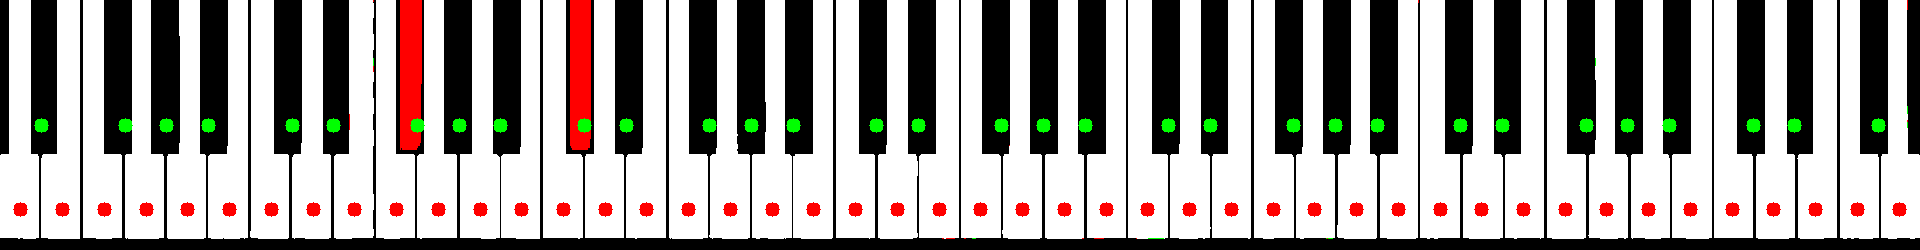

In [11]:
from src.image import frame_to_pil

# seq = np.vstack(frames)
chords = frames[0].copy()
h, w, c = chords.shape

w_sp, b_sp = spacings

for x in w_sp:
    cv2.circle(chords, (int(x * w), h - h // 6), 2, (255, 0, 0), 10)

for x in b_sp:
    cv2.circle(chords, (int(x * w), h // 2), 2, (0, 255, 0), 10)

frame_to_pil(chords)

In [111]:
import abjad
# NOTE: Sharp is coded as <note_name>s
# NOTE: Flat  is coded as <note_name>f


# duration = abjad.Duration(1, 4)
# notes = [abjad.Note(pitch, duration) for pitch in range(8)]
# staff = abjad.Staff(notes)

staff = abjad.Staff([], name="Left-Hand")

for notes in music['left-hand']:
    voices = []
    if len(notes):
        for note in notes:
            name, octave = note.split('-')
            
            name = name.lower().replace('#', 's').replace('b', 'f')
            pitch = "'" * (int(octave) - 3) + ',' * (3 - int(octave))
            
            duration = abjad.Duration(1, 8)
            note = abjad.Note(name + pitch, duration)

            voice = abjad.Voice([note])
            voices.append(voice)
    else:
        voice = abjad.Voice('r ')
        voices = [voice]

    print(voices)
    chords = abjad.Staff(voices, name="Left-Hand", simultaneous=True)

    staff.append(chords)

key_signature = abjad.KeySignature(
    abjad.NamedPitchClass("fs"), abjad.Mode("major")
)

clef = abjad.Clef(name='bass')
abjad.attach(key_signature, staff[0][0][0])
abjad.attach(clef, staff[0][0][0])

print(music['left-hand'])
score = abjad.Score([staff], name="Example_Score")

# abjad.persist(score).as_png(preview=True)

abjad.show(score)

[Voice('r4')]
[Voice('cs8'), Voice('fs,8')]
[Voice('fs,8')]
[Voice('cs8'), Voice('fs,8')]
[Voice('cs8'), Voice('fs,8')]
[Voice('cs8'), Voice('fs,8')]
[Voice('fs,8')]
[Voice('cs8'), Voice('fs,8')]
[Voice('cs8'), Voice('fs,8')]
[Voice('fs,8')]
[Voice('cs8'), Voice('fs,8')]
[[], ['C#-3', 'F#-2'], ['F#-2'], ['C#-3', 'F#-2'], ['C#-3', 'F#-2'], ['C#-3', 'F#-2'], ['F#-2'], ['C#-3', 'F#-2'], ['C#-3', 'F#-2'], ['F#-2'], ['C#-3', 'F#-2']]


[[], ['Bb-4', 'Db-4', 'Bb-3'], [], ['Bb-4', 'Db-4', 'Bb-3'], [], ['Bb-4', 'Db-4', 'Bb-3'], ['Db-5'], ['Db-5', 'Db-4'], ['Db-5', 'Db-4'], ['Db-5', 'Db-4'], ['Bb-4', 'Bb-3'], ['Bb-4', 'Db-4', 'Bb-3'], ['Ab-4'], ['Ab-4', 'Bb-3'], ['Gb-4'], [], ['Gb-4'], ['Bb-3'], ['Gb-4', 'Bb-3'], ['Gb-4', 'Bb-3']]
[2, 4, 2, 10, 2, 4, 1, 6, 1, 11, 1, 11, 1, 5, 6, 1, 5, 2, 4, 24]


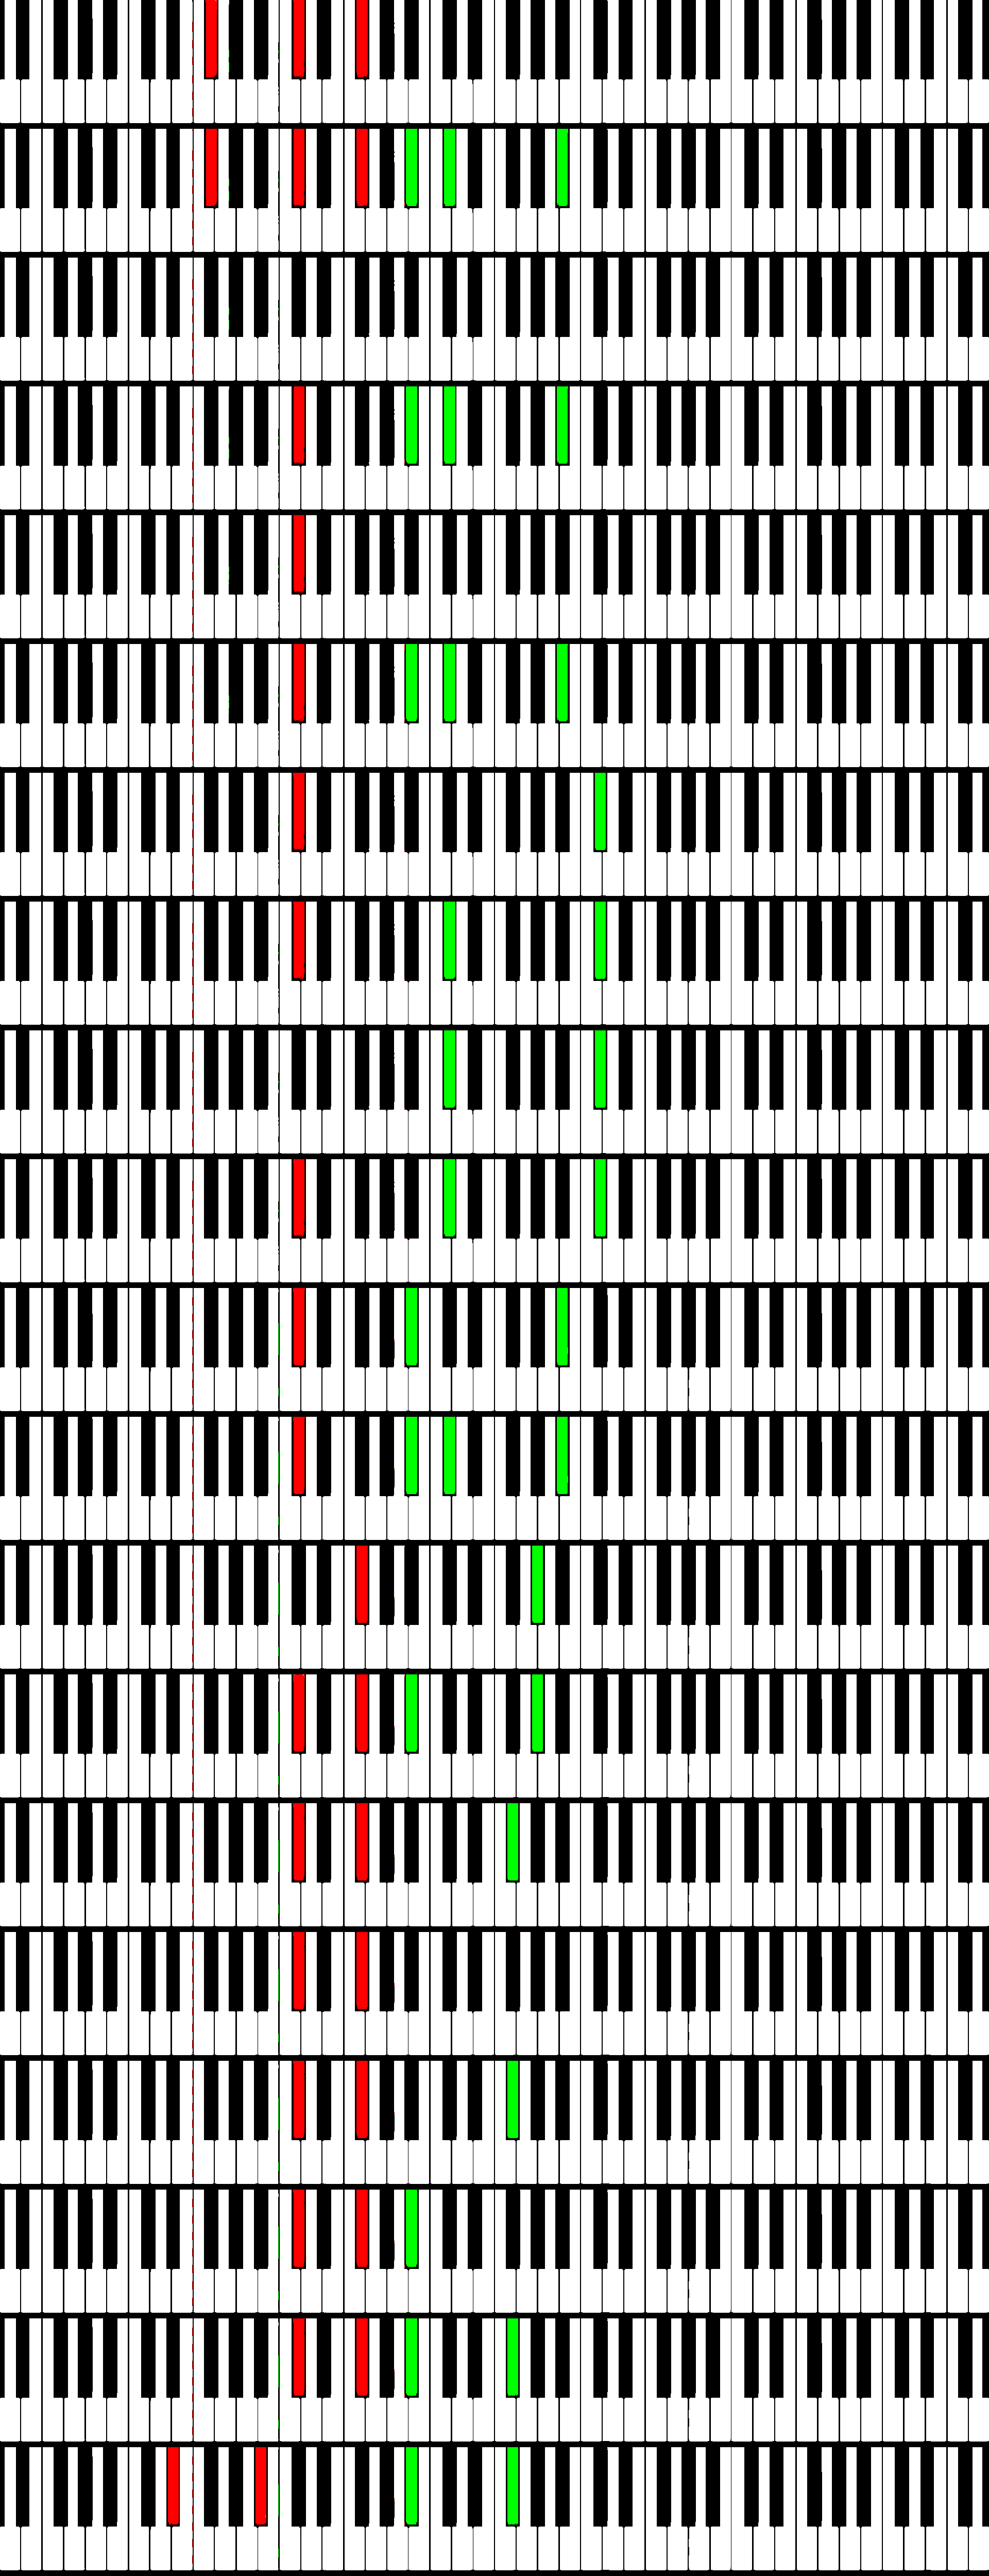

In [25]:
from src.image import frame_to_pil

# print(music['left-hand'])
window=slice(80, 100)
print(music['right-hand'][window])
print(times[window])
frame_to_pil(np.vstack(frames[window]))

In [32]:
import cv2

video_path = 'video/exile - Taylor Swift & Bon Iver  Piano Tutorial.mp4'

# Load the video & check correct opening
capture = cv2.VideoCapture(video_path)

# Skip the intro frames if necessary
skip_intro = 500
while skip_intro:
    ret, frame = capture.read()
    skip_intro -= 1

frames = [cv2.cvtColor(capture.read()[1][-250:], cv2.COLOR_BGR2RGB) for i in range(1000)]

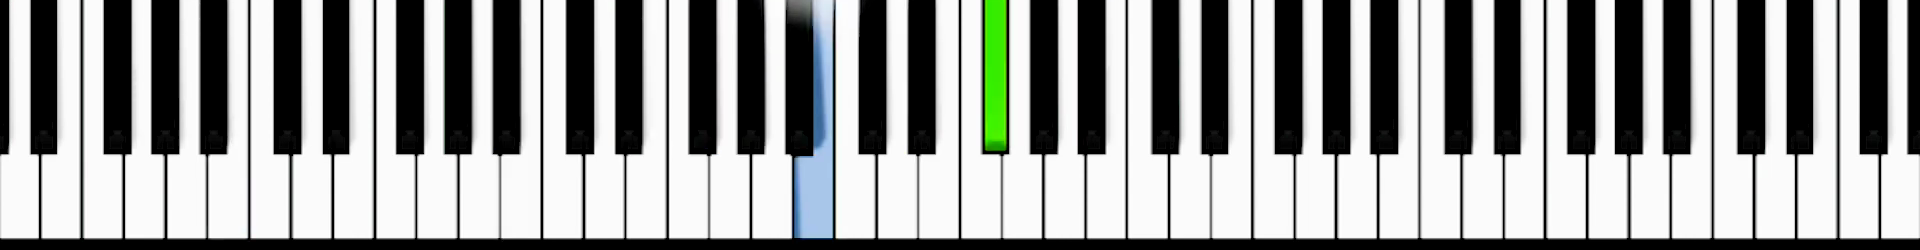

In [37]:
from PIL import Image

img = Image.fromarray(frames[850])
img

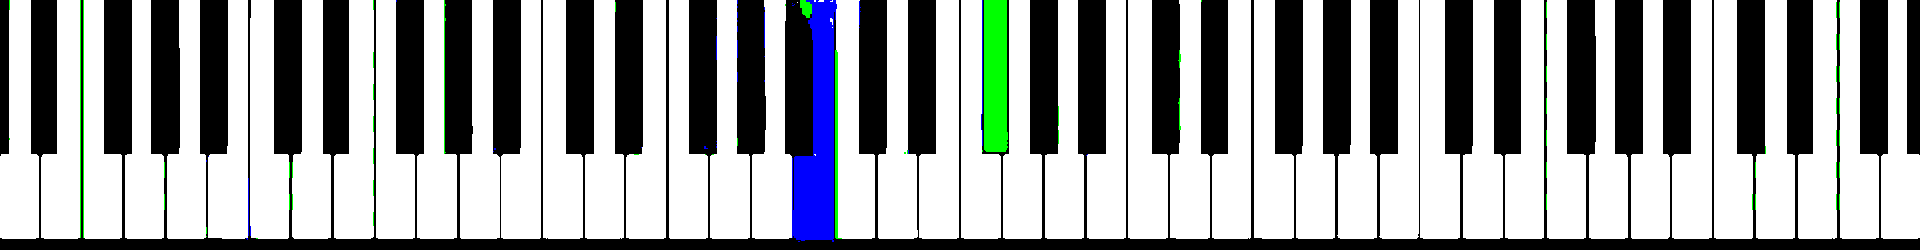

In [66]:
from PIL import ImageEnhance

palette = [(255, 255, 255), (0, 0, 0), (0, 0, 255), (0, 255, 0)]

# Unroll the palette into a flat list as this is what PIL expects
palette = [v for rgb in palette for v in rgb]

# Zero-pad the palette to 256 RGB colors, i.e. 768 values and apply to image
palette += (768 - len(palette)) * [0]

# Make tiny palette Image, one black pixel
img_palette = Image.new('P', (1, 1))
img_palette.putpalette(palette)

img = Image.fromarray(frames[850])

# Enhance color saturation to avoid artifact of quantization
enhancer = ImageEnhance.Color(img)
img = enhancer.enhance(30)

img = img.quantize(palette=img_palette,dither=Image.Dither.NONE).convert('RGB')
img

In [70]:
import importlib
import src.utils.io
importlib.reload(src.utils.io)
from src.utils.io import Frame

frame = Frame(frames[850], 10)

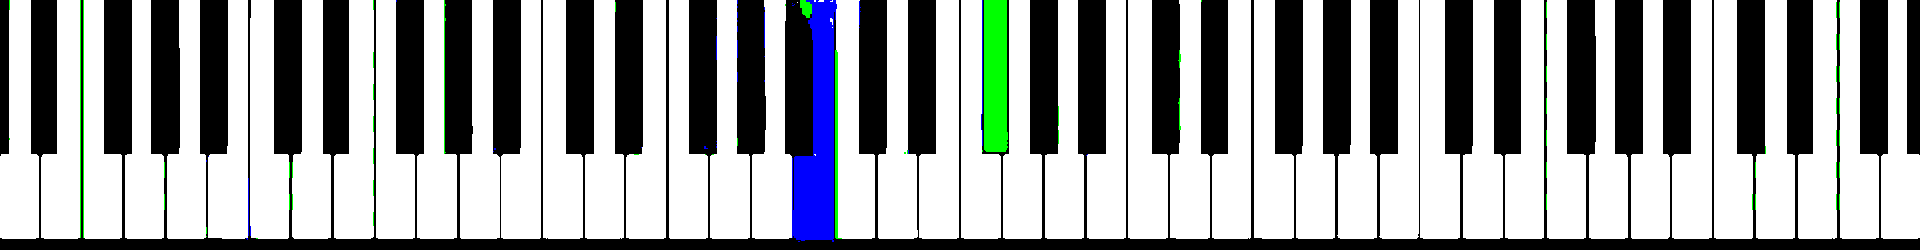

In [71]:
Image.fromarray(frame.quantized)

In [84]:
from src.utils.misc import Box

# mask = cv2.inRange(frame.quantized, (0, 0, 100), (0, 0, 255))
mask = cv2.inRange(frame.quantized, (0, 100, 0), (0, 255, 0))

# Get the contours of the objects in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out the contours that are too small
objects = sorted([
    Box(*cv2.boundingRect(contour)) / (1920, 250)
    for contour in contours
    if cv2.contourArea(contour) > (1920 * 250) / (8 * 7 * 10)
])

error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/contours_new.cpp:330: error: (-2:Unspecified error) in function 'static shared_ptr<ContourScanner_> ContourScanner_::create(cv::Mat, int, int, cv::Point)'
> Modes other than RETR_FLOODFILL and RETR_CCOMP support only CV_8UC1 images (expected: 'img.type() == CV_8UC1'), where
>     'img.type()' is 16 (CV_8UC3)
> must be equal to
>     'CV_8UC1' is 0 (CV_8UC1)


In [82]:
(1920 * 250) / (8 * 7 * 10)

857.1428571428571

In [83]:
objects

[Box(x=0.5125, y=0.0, w=0.0125, h=0.608, pos_thr=0.005208333333333333, dim_thr=0.005208333333333333)]

In [68]:
import importlib
import src.utils.io
import src.utils.misc
importlib.reload(src.utils.misc)
importlib.reload(src.utils.io)
from src.utils.io import extract_notes
from src.utils.misc import get_layout
from src.utils.misc import Configs, RawChord, BLUE, GREEN

video_path = 'video/exile - Taylor Swift & Bon Iver  Piano Tutorial.mp4'

SKIP = 150
STOP = 2500

config = Configs(
    BPM=75,
    MIN_UNIT=16,
    central_octave=3,
    start_octave = 1,
    num_octaves=7,
    first_note='D',
    last_note='G',
    notation='flat',
)

layout = get_layout(
    config,
)

music, info, frames = extract_notes(
    video_path,
    layout,
    note_color={
        'left' : BLUE,
        'right': GREEN,
    },
    skip_intro=SKIP,
    early_stop=STOP,
    configs=config,
    verbose=True,
)

# If there is a difference in onset times, we need to align them
# by shifting the notes to the right or left.
if abs(diff := info['notes_onset']['left'] - info['notes_onset']['right']) > 2 * info['video_fps']:
    if diff < 0: music['right'].insert(0, RawChord('R', time=abs(diff), info=config))
    else:        music['left_'].insert(0, RawChord('R', time=abs(diff), info=config))

Extracting Frames: 100%|██████████| 2500/2500 [00:43<00:00, 58.09it/s]


In [4]:
from src.utils.misc import to_ms

def split_invalid(chords):
    out = []
    for chord in chords:
        if not chord.valid:
            print(chord)
            d1 = chord.duration.equal_or_lesser_power_of_two
            d2 = chord.duration - d1
            print(chord.duration, d1, d2)
            t1 = to_ms(d1, chord._info)
            t2 = to_ms(d2, chord._info)
            out.append(RawChord(chord._notes, chord._info, t1))
            out.append(RawChord(chord._notes, chord._info, t2))
        else:
            out.append(chord)
    return out

In [63]:
# import importlib
# import src.utils.io
# import src.utils.misc
# importlib.reload(src.utils.misc)
# importlib.reload(src.utils.io)
from src.utils.misc import mark_sustained, fix_invalid

for hand in music:
    music[hand] = mark_sustained(music[hand])
    music[hand] = fix_invalid(music[hand])

Triggered for Bb-3 (5⛔️) (1034 ms) Gb-4 (5⛔️) (1034 ms)
With next Gb-4 (1♬) 🔕 (200 ms)
With post Bb-3 (1♬) (200 ms) Gb-4 (1♬) 🔕 (200 ms)
Triggered for Bb-3 (5⛔️) (1034 ms) Gb-4 (5⛔️) (1034 ms)
With next Gb-4 (1♬) 🔕 (200 ms)
With post Bb-3 (1♪) (400 ms) Gb-4 (1♪) 🔕 (400 ms)


In [69]:
sum([not c.valid for c in music['right']])

82

In [57]:
frames['right'][200].elapsed / 1000

66.6666

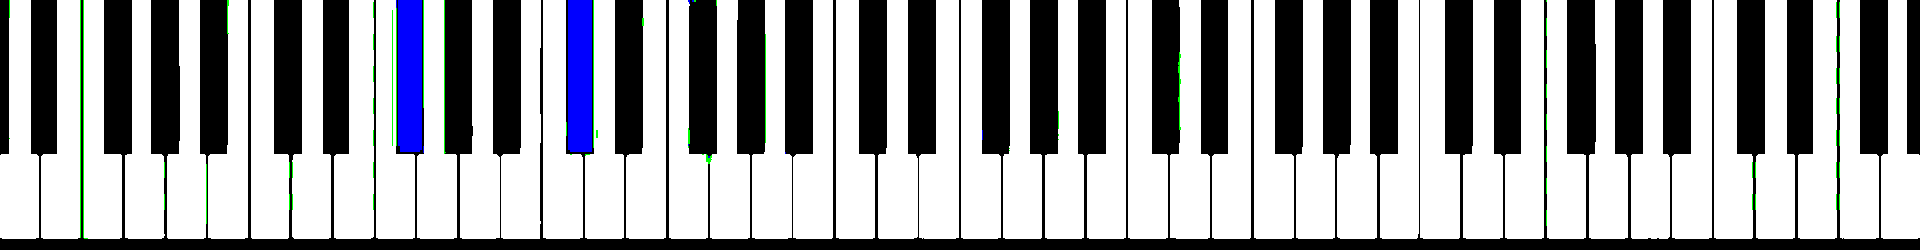

In [60]:
from PIL import Image

Image.fromarray(frames['right'][202].quantized)

In [7]:
tmp = split_invalid(music['right'])

Db-4 (3♬) (567 ms) Db-5 (0💀) 🔕 (0 ms)
3/16 1/8 1/16
Db-4 (3♬) (601 ms) Db-5 (0💀) 🔕 (0 ms)
3/16 1/8 1/16
Bb-3 (0💀) 🔕 (0 ms) Bb-4 (0💀) 🔕 (0 ms) Db-4 (1♪) (367 ms)
1/8 1/8 0
Bb-3 (1♬) (167 ms) Ab-4 (0💀) 🔕 (0 ms)
1/16 1/16 0
Bb-3 (0💀) 🔕 (0 ms) Gb-4 (7♬) (1368 ms)
7/16 1/4 3/16
Db-4 (3♬) (567 ms) Db-5 (0💀) 🔕 (0 ms)
3/16 1/8 1/16
Db-4 (3♬) (567 ms) Db-5 (0💀) 🔕 (0 ms)
3/16 1/8 1/16
Bb-3 (1♬) (133 ms) Ab-4 (0💀) 🔕 (0 ms)
1/16 1/16 0
Bb-3 (0💀) 🔕 (0 ms) Gb-4 (7♬) (1368 ms)
7/16 1/4 3/16
Bb-3 (5⛔️) (1034 ms) Gb-4 (0💀) (0 ms)
5/16 1/4 1/16
Gb-4 (0💀) 🔕 (0 ms) Ab-3 (1♪) (367 ms)
1/8 1/8 0
B-3 (1♪) (334 ms) Bb-4 (0💀) 🔕 (0 ms) Eb-4 (0💀) 🔕 (0 ms)
1/8 1/8 0
Bb-3 (5⛔️) (1034 ms) Gb-4 (0💀) (0 ms)
5/16 1/4 1/16
Gb-4 (0💀) 🔕 (0 ms) Ab-3 (1♪) (367 ms)
1/8 1/8 0
B-3 (1♬) (167 ms) B-4 (0💀) 🔕 (0 ms) Eb-4 (0💀) 🔕 (0 ms)
1/16 1/16 0
B-3 (1♪) (300 ms) Bb-4 (0💀) 🔕 (0 ms)
1/8 1/8 0
Ab-4 (0💀) 🔕 (0 ms) Eb-4 (1♪) (367 ms)
1/8 1/8 0
R (5⛔️) (1034 ms)
5/16 1/4 1/16
Bb-3 (0💀) 🔕 (0 ms) Gb-4 (3♪) (1201 ms)
3/8 1/4 1/8
Ab-5 (0💀

In [67]:
sum([not c.valid for c in music['right']])

7

In [12]:
[str(c) for c in tmp[-50:]]

['Gb-4 (1♬) (200 ms)',
 'Bb-4 (1♬) (200 ms)',
 'Ab-4 (1♪) (400 ms) Db-4 (1♪) (400 ms)',
 'Ab-4 (1♪) (334 ms) Db-4 (1♪) (334 ms)',
 'Ab-4 (1♪) (334 ms) Db-4 (1♪) (334 ms)',
 'Gb-4 (1♬) (200 ms)',
 'Bb-3 (2♩♩♩♩) 🔕 (6400 ms) Gb-4 (2♩♩♩♩) (6400 ms)',
 'Bb-3 (2♩♩♩♩) 🔕 (6400 ms) Gb-4 (2♩♩♩♩) (6400 ms)',
 'R (1⏸️) (834 ms)',
 'Bb-4 (1♩) (801 ms) Db-5 (1♩) (801 ms) Bb-5 (1♩) (801 ms)',
 'Ab-5 (0💀) 🔕 (0 ms) Bb-4 (0💀) (0 ms) Db-5 (0💀) (0 ms)',
 'Ab-5 (0💀) 🔕 (0 ms) Bb-4 (0💀) (0 ms) Db-5 (0💀) (0 ms)',
 'Gb-5 (1♩♩♩♩) 🔕 (3200 ms) Bb-4 (1♩♩♩♩) (3200 ms) Db-5 (1♩♩♩♩) (3200 ms)',
 'Gb-5 (1♩♩♩♩) 🔕 (3200 ms) Bb-4 (1♩♩♩♩) (3200 ms) Db-5 (1♩♩♩♩) (3200 ms)',
 'R (1⏸️) (801 ms)',
 'Bb-4 (1♩) (801 ms) Db-5 (1♩) (801 ms) Bb-5 (1♩) (801 ms)',
 'Ab-5 (0💀) 🔕 (0 ms) Bb-4 (0💀) (0 ms) Db-5 (0💀) (0 ms)',
 'Ab-5 (0💀) 🔕 (0 ms) Bb-4 (0💀) (0 ms) Db-5 (0💀) (0 ms)',
 'Gb-5 (0💀) 🔕 (0 ms) Bb-4 (0💀) (0 ms) Db-5 (0💀) (0 ms)',
 'Gb-5 (0💀) 🔕 (0 ms) Bb-4 (0💀) (0 ms) Db-5 (0💀) (0 ms)',
 'R (1⏸️) (801 ms)',
 'Bb-4 (1♩) (834 ms) Db-

In [71]:
[str(c) for c in music['right'][-150:]]

['Db-4 (3♬) (567 ms) Db-5 (3♬) (567 ms)',
 'Bb-3 (1♪) (400 ms) Bb-4 (1♪) (400 ms)',
 'Ab-4 (0💀) (67 ms)',
 'Ab-4 (1♬) (133 ms) Bb-3 (1♬) (133 ms)',
 'Gb-4 (1♬) (234 ms)',
 'R (0💀) (33 ms)',
 'Gb-4 (1♬) (167 ms)',
 'Bb-3 (0💀) (33 ms)',
 'Bb-3 (7♬) (1368 ms) Gb-4 (7♬) (1368 ms)',
 'Eb-3 (1♬) (200 ms)',
 'Ab-3 (5⛔️) (1034 ms)',
 'Eb-3 (1♬) (200 ms)',
 'Gb-3 (1♪) (400 ms)',
 'Eb-3 (1♬) (200 ms)',
 'R (1⏸️) (400 ms)',
 'B-3 (1♪) (400 ms) Bb-4 (1♪) (400 ms) Eb-4 (1♪) (400 ms)',
 'Gb-4 (1♪) (434 ms)',
 'Bb-4 (1♪) (400 ms)',
 'Db-4 (1♪) (400 ms) Ab-3 (1♪) (400 ms) Gb-4 (1♪) (400 ms)',
 'Bb-4 (1♪) (400 ms)',
 'Gb-4 (1♪) (400 ms)',
 'F-4 (1♬) (200 ms)',
 'Bb-3 (5⛔️) (1034 ms) Gb-4 (5⛔️) (1034 ms)',
 'Gb-4 (1♬) (200 ms)',
 'Bb-3 (1♬) (200 ms) Gb-4 (1♬) (200 ms)',
 'R (0💀) (33 ms)',
 'Bb-3 (1♬) (167 ms) Gb-4 (1♬) (167 ms)',
 'R (0💀) (33 ms)',
 'Bb-3 (1♬) (167 ms) Gb-4 (1♬) (167 ms)',
 'F-4 (1♬) (200 ms) Ab-3 (1♬) (200 ms)',
 'R (0💀) (67 ms)',
 'F-4 (1♬) (133 ms) Ab-3 (1♬) (133 ms)',
 'R (0💀) (67 m

In [106]:
from abjad import Chord, MetronomeMark, Note, Score, Voice, Staff, StaffGroup
from abjad import show, Meter, Duration
import abjad
from src.utils.misc import get_leaf

# Attach a bass clef to the first note
from abjad import Clef
from abjad import attach
from abjad import mutate

signature = abjad.TimeSignature((4, 4))

def put_barlines(chords : Voice, signature):
    i = 0
    while i < len(chords):
        duration = Duration(0, 4)
        while duration < signature and i < len(chords):
            duration += chords[i].written_duration
            i += 1
        if i < len(chords):
            abjad.attach(abjad.BarLine('|'), chords[i-1])
    
    return chords

staffs = {}
for hand, voice in music.items():
    staffs[hand] = Staff([
            Voice([chord.abjad for chord in voice if chord], name=f'{hand} Voice'),
        ], name=f'{hand} Staff'
    )


abj_key = abjad.KeySignature(
    abjad.NamedPitchClass('gf'), abjad.Mode('major')
)

metronome_note = Duration((1, config.BPM_UNIT))
abj_mark = MetronomeMark(
    reference_duration = metronome_note,
    units_per_minute   = config.BPM,
    textual_indication = 'Nostalgico',
)

meter = Meter((4, 4), preferred_boundary_depth=0)
# Meter.rewrite_meter(staffs['right'], meter)

clef = {
    'left' : Clef('bass'),
    'right': Clef('bass'),
}
for hand, staff in staffs.items():
    # Meter.rewrite_meter(staff, meter)
    attach(clef[hand], get_leaf(staff))
    attach(abj_key,    get_leaf(staff))
    attach(signature,   get_leaf(staff))

# Manual adjustments
attach(Clef('treble'), get_leaf(staffs['right'][0][27]))

staff = StaffGroup([staffs[k] for k in ('right', 'left')], name='Staff Group', lilypond_type='PianoStaff', simultaneous=True)
score = Score([staff], name='Score')
preamble = r'''
    #(set-global-staff-size 20)
    \header {
        composer = \markup { Render via SheetPiano }
        subtitle = \markup { A song from Bon Iver & Taylor Swift }
        title = \markup { Exile }
    }

    \layout {
        indent = 1
    }
'''

file = abjad.LilyPondFile([preamble, score])

show(file, output_directory='out', render_prefix='test', should_open=False)

AssignabilityError: not assignable duration: Duration(9, 16).

In [411]:
import importlib
import src.utils.io
import src.utils.misc
importlib.reload(src.utils.misc)
importlib.reload(src.utils.io)
from src.utils.misc import RawChord, RawNote

RawChord({RawNote('Ab-8', 4), RawNote('Gb-8', 0)})

<af'''' gf''''>

In [412]:
from abjad import Voice, Note, Chord, Duration, Staff

notes = ' '.join([repr(note) for note in out[0][0]])
notes
# voice = Voice()

'Gb-2 (0♩) (3237 ms)'

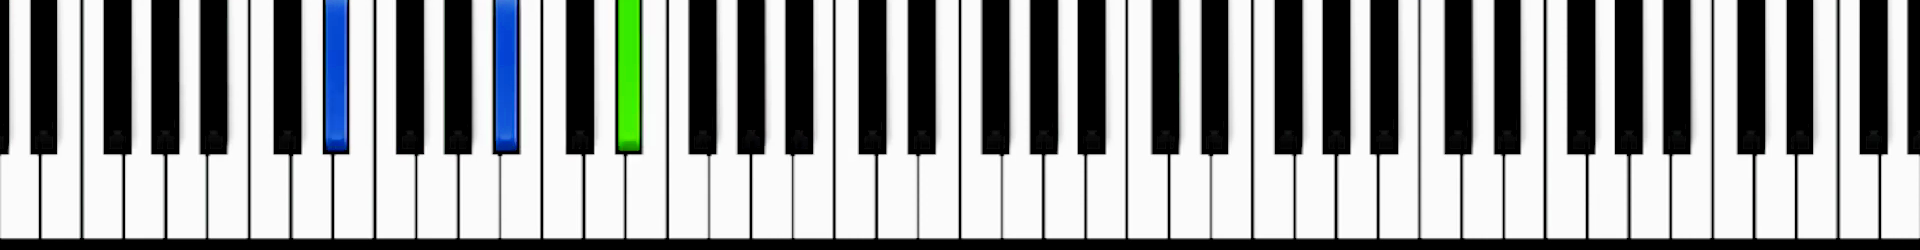

In [171]:
import cv2
from src.image import frame_to_pil
frame_to_pil(cv2.cvtColor(frames[6].image, cv2.COLOR_HSV2RGB))